# matching to HSC by number density

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy.interpolate import interp1d

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.cosmology import FlatLambdaCDM

import glob
import os
import pickle
    
plt.rc('text', usetex=True)

In [2]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle

    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)
        pklFile.close()

        return data
    else:
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    

def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=150):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    

    return sma_common, mu

In [3]:
#data
illustris_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_1d_masses.npy'
tng_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_1d_masses.npy'

illustris_iso_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'
tng_iso_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'

HSC_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_wide_massive_fastlane_imgsub_master_use_camira.fits'

In [12]:
#masses
illustris_masses_1d = np.load(illustris_masses_file)
illustris_m_1d_100 = np.array([gal[2] for gal in illustris_masses_1d])

tng_masses_1d = np.load(tng_masses_file)
tng_m_1d_100 = np.array([gal[2] for gal in tng_masses_1d])

#isos
illustris_isos = load_pkl(illustris_iso_file)
tng_isos = load_pkl(tng_iso_file)

In [5]:
def compute_smf(log_masses, volume, n_bins, min_mass=None, max_mass=None):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
    """
    if not min_mass:
        min_mass = min(log_masses)
    if not max_mass:
        max_mass = max(log_masses)
     
    #Unnormalized histogram and bin edges
    Phi,edg = np.histogram(log_masses,bins=n_bins, range=[min_mass, max_mass]) 
    
    # Poisson error
    err = np.sqrt(Phi)
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    m_centers   = edg[0:-1] + dM/2.           
    
    print Phi , float(volume) , dM  
    #Normalize to volume and bin size
    Phi   = Phi / float(volume) / dM        
    log_phi= np.log10(Phi) 

    # Also normalize the error
    err = err / float(volume) / dM 
    
    return m_centers, Phi, err

# Params

In [4]:
# h0 
HSMALL = 0.70
H0 = 70.0

# S16A 
S16A_AREA = 144.7  # deg^2

#Illlustris
volume_illustris=106.5**3 #Mpc^3
sm_min=11.2
sm_max=12.4

pixel_scale=2.*800./300 #kpc/pixel
print 'pixel scale: ', pixel_scale

pixel scale:  5.33333333333


In [9]:
n_bins_hsc = 10
n_bins_illustris= 4

## HSC 

In [11]:
#HSC
fastMaster = Table.read(HSC_file, format='fits')

hsc_m_100 = fastMaster['logm_100']

print max(fastMaster['MSTAR'])
print min(fastMaster['MSTAR'])


# fastPhotoz = Table.read(os.path.join(envir['sbpsum'],'s16a_wide_massive_fastlane_pzbright_imgsub_master_use.fits'),
#     format='fits')


# Stellar mass function
cosmo = FlatLambdaCDM(H0=H0, Om0=0.300)
s16a_vol = ((cosmo.comoving_volume(0.52) - cosmo.comoving_volume(0.19)) * 
            (S16A_AREA / 41253.0)).value
print("# Volume for Horizon : %f Mpc^3" % s16a_vol)
m_hsc, smf_hsc, err_hsc = compute_smf(fastMaster['MSTAR'], s16a_vol, n_bins_hsc)

m100_hsc, smf100_hsc, err100_hsc = compute_smf(fastMaster['logm_100'], s16a_vol, n_bins_hsc)
m30_hsc, smf30_hsc, err30_hsc = compute_smf(fastMaster['logm_30'], s16a_vol, n_bins_hsc)

s16aMLow1 = np.nanpercentile(smf_hsc, 3.0, axis=0)
s16aMUpp1 = np.nanpercentile(smf_hsc, 97.0, axis=0)
s16aMMed1 = np.nanmedian(smf_hsc, axis=0)

#profile data
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
hscMedProf_114_116 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.4_11.6.medprof.npy')[0]
hscMedProf_116_118 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.6_11.8.medprof.npy')[0]
hscMedProf_118_120 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.8_12.0.medprof.npy')[0]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)

12.2632
10.7527
# Volume for Horizon : 102635118.944925 Mpc^3
[  31  383 1521 2826 3154 1760  520   85   11    2] 102635118.945 0.151054382324
[ 945 1402 1900 2208 1976 1160  497  161   40    4] 102635118.945 0.116992146567
[  28  787 1508 2255 2731 1966  803  188   25    2] 102635118.945 0.12385869438


In [20]:
np.log10(220./102635118.945/0.12)
520./102635118.945

-5.2952926463254286

# SMFs 

In [49]:
m_illustris, smf_illustris, err_illustris = compute_smf(illustris_m_1d_100, volume_illustris,n_bins_illustris)
# m_tng, smf_tng, err_tng = compute_smf(tng_m_cat, volume_illustris,n_bins)

In [55]:
print np.log10(smf_illustris)
print np.log10(smf100_hsc)

[-3.31941388 -3.41833919 -3.93786429 -4.57468639]
[-4.10402089 -3.93270469 -3.8006991  -3.73545363 -3.78366576 -4.01499471
 -4.38309631 -4.87262682 -5.47739271 -6.47739271]


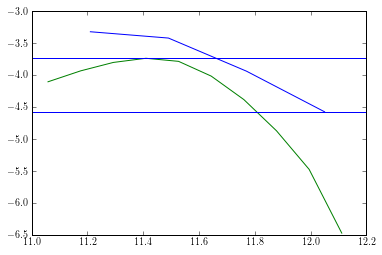

In [56]:
plt.plot(m_illustris, np.log10(smf_illustris))
plt.plot(m100_hsc, np.log10(smf100_hsc))
plt.axhline(-4.57468639)
plt.axhline(-3.73545363)
plt.show()

In [84]:
# x=np.linspace(-5,-3,10)
m_illustris_low = interp1d(np.log10(smf_illustris), m_illustris, fill_value='extrapolate')(-3.73545363)
m_illustris_high = interp1d(np.log10(smf_illustris), m_illustris, fill_value='extrapolate')(-4.57468639)

m_hsc_low = interp1d(np.log10(smf100_hsc), m100_hsc, fill_value='extrapolate')(-3.73545363)
m_hsc_high = interp1d(np.log10(smf100_hsc), m100_hsc, fill_value='extrapolate')(-4.57468639)

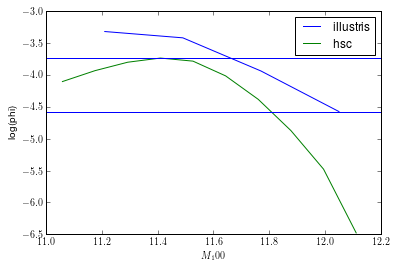

In [96]:
plt.plot(m_illustris, np.log10(smf_illustris), label='illustris')
plt.plot(m100_hsc, np.log10(smf100_hsc), label='hsc')
plt.axhline(-4.57468639)
plt.axhline(-3.73545363)

# plt.axvline(m_illustris_low, c='r')
# plt.axvline(m_illustris_high, c='g')
# plt.axvline(m_hsc_low, c='r')
# plt.axvline(m_hsc_high, c='g')

plt.legend()
plt.xlabel(r'$M_100$')
plt.ylabel('log(phi)')
plt.show()

### find Illustris galaxies in this mass range 

In [87]:
illustris_galaxies_in_range = illustris_m_1d_100[(illustris_m_1d_100>m_illustris_low) \
                                                 & (illustris_m_1d_100<m_illustris_high)]

In [88]:
illustris_galaxies_in_range

array([ 11.99668755,  11.88766575,  11.86032596,  11.89219268,
        12.02630092,  12.01654294,  11.72882217,  11.68625112,
        11.82950628,  11.70985466,  11.88664424,  11.72333228,
        11.69676141,  11.77802118,  11.84441657,  11.73576554,
        11.67417937,  11.79895627,  11.82447662,  11.8182714 ,
        11.7588756 ,  11.79358776,  11.76216819,  11.70037213,
        11.74883225,  11.71497238,  11.69388618,  11.68526278,
        11.80914448,  11.87171852,  11.80774745,  11.7041328 ,
        11.73330839,  11.69008013,  11.66214572])

### find HSC galaxies in this mass range  

In [91]:
hsc_galaxies_in_range = hsc_m_100[(hsc_m_100>m_hsc_low) \
                                                 & (hsc_m_100<m_hsc_high)]

In [93]:
max(hsc_galaxies_in_range), min(hsc_galaxies_in_range)

(11.806282046569439, 11.40953541374159)

# NO SMF 

New plan: Get HSC number density of top most massive galaxies (M_100 > 11.8). Number divided by volume. Multiply that number density by Illustris volume to get Illustris number of top galaxies. Compare those.

In [5]:
#profile data
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
HSC_file = hsc_data + 's16a_wide2_massive_sbp_cog_good.fits'

hsc_table = Table.read(HSC_file, format='fits')

hsc_sbp = hsc_table['sbp']
hsc_cog = hsc_table['cog']
hsc_m100 = hsc_table['logm_100']


rsma = np.arange(0.4, 4.2, 0.01)



In [6]:
s16a_area = 145.0

cosmo = FlatLambdaCDM(H0=70.0, Om0=0.300)

s16a_vol = ((cosmo.comoving_volume(0.50) - cosmo.comoving_volume(0.19)) * 
            (s16a_area / 41254.0)).value

hsc_volume = s16a_vol

### M > 11.75 

In [7]:
mask = hsc_m100 > 11.75

hscMedProf =  np.nanmedian(hsc_sbp[mask], axis=0)

In [8]:
hsc_N = len(hsc_table[mask])
print hsc_N

hsc_n = hsc_N / hsc_volume
print hsc_n

566
6.13533081323e-06


In [9]:
# hsc_n = 3.501257690237704e-06

#add 10% because 10% of HSC galaxies do not have useful 1-D profile due to various reasons
hsc_n = hsc_n*1.1

In [15]:
Illustris_N = int(volume_illustris * hsc_n)
TNG_N = Illustris_N
print Illustris_N

8


In [11]:
def get_top_galaxies(isos, masses, n):
    combo = zip(isos, masses)
    combo.sort(key = lambda t: t[1], reverse=True)
    
    print [c[1] for c in combo[:n+1]]
    return [c[0] for c in combo[:n]]
        
    

In [16]:
illustris_top_isos = get_top_galaxies(illustris_isos, illustris_m_1d_100, Illustris_N)
tng_top_isos = get_top_galaxies(tng_isos, tng_m_1d_100, TNG_N)

[12.189743936667702, 12.144243869116245, 12.132747052922708, 12.087181825632131, 12.060866266250496, 12.056198031714388, 12.026300922085731, 12.016542938351169, 11.996687552178836]
[12.300583497577597, 12.152924581941789, 12.116283745613924, 12.109033521196325, 12.076816771414059, 12.036410312433476, 12.035373087197236, 12.010246853527706, 11.93483659737562]


## PLOTS

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


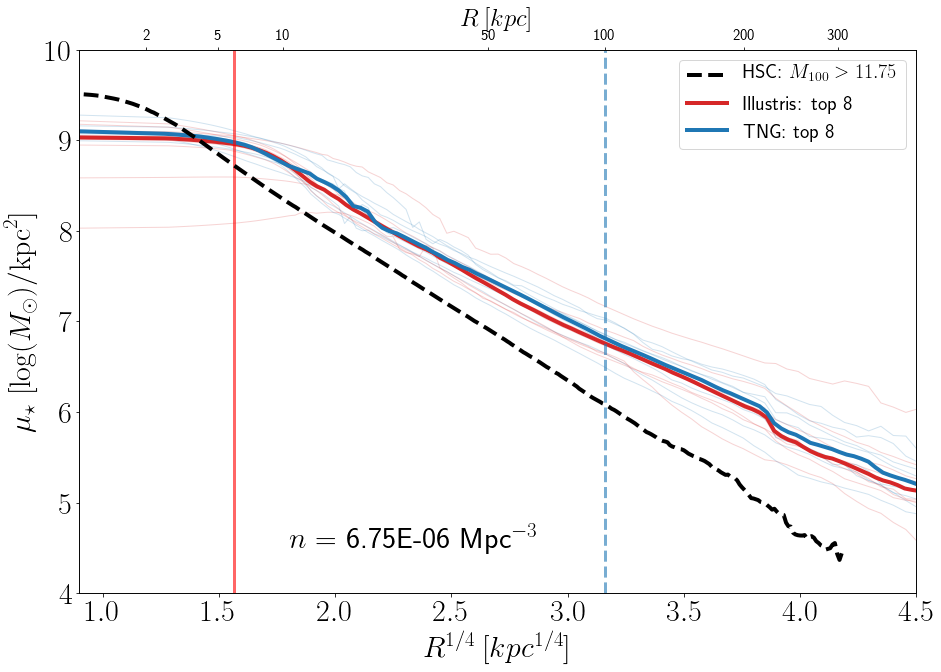

In [19]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

######################################################################################################################
# plot
######################################################################################################################
#hsc
plt.plot(rsma, hscMedProf, linestyle='--', linewidth=4.0, c='k',
         alpha=1, zorder=8, label='HSC: $M_{100} > 11.75 $')
  

for illustris_iso, tng_iso in zip(illustris_top_isos,tng_top_isos):   

        ax1.plot((illustris_iso['sma'] * pixel_scale) ** 0.25,
             np.log10(illustris_iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=1.0, c=u'#d62728', alpha=0.2, 
                 label='_nolegend_')
        ax1.plot((tng_iso['sma'] * pixel_scale) ** 0.25,
             np.log10(tng_iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=1.0, c=u'#1f77b4', alpha=0.2, 
                 label='_nolegend_')
            
## median profiles
median_sma_illustris, median_mu_illustris = get_median_profile(illustris_top_isos, pixel_scale = pixel_scale)
median_sma_tng, median_mu_tng = get_median_profile(tng_top_isos, pixel_scale = pixel_scale)

ax1.plot(median_sma_illustris, median_mu_illustris+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728',
         alpha=1, label='Illustris: top 8')
ax1.plot(median_sma_tng, median_mu_tng+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4',
         alpha=1, label='TNG: top 8')


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)

ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
ax1.text(1.8, 4.5, r'$n = $ {:01.2E} Mpc$^{{-3}}$'.format(hsc_n), size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris_matched_n.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()